# 02 - Hypothesis Formulation

## Hypotheses

Based on the business problem and exploratory data analysis, the following hypotheses are proposed:

1. **Supervised Learning Performance**  
   Supervised learning models trained on the selected environmental predictors will be able to predict gross primary productivity (GPP) with meaningful accuracy, demonstrating that the predictors contain usable signal.

2. **Clustering Utility**  
   Unsupervised learning techniques (e.g., clustering) may reveal distinct groupings of observations that correspond to site-level differences or environmental conditions.

3. **Predictor Influence**  
   Radiation-, temperature-, and water-related features (e.g., `NETRAD`, `PPFD_IN`, `TA_F`, `VPD_F`) are expected to be the strongest contributors to variation in GPP.

4. **Site-Level Differences**  
   The distribution of GPP will differ across sites, reflecting site-specific environmental conditions and local variability.


## 0. Load processed data from Notebook 01

In [1]:

from pathlib import Path
import pandas as pd

# Resolve repo paths (works from repo root or from notebooks/)
ROOT = Path.cwd()
if ROOT.name == "notebooks":
    ROOT = ROOT.parent

DATA_PROCESSED = ROOT / "data" / "processed"
RESULTS = ROOT / "results"
RESULTS.mkdir(parents=True, exist_ok=True)

# Expected files produced by 01_data_exploration.ipynb
PROCESSED_FILE = DATA_PROCESSED / "df_processed.csv"
SCALED_FILE    = DATA_PROCESSED / "df_scaled.csv"  # optional (if you saved it)

# Load processed data
assert PROCESSED_FILE.exists(), f"Processed file not found: {PROCESSED_FILE}. Run 01_data_exploration first."
df_all = pd.read_csv(PROCESSED_FILE)

# Load scaled data if available (some analyses may prefer it)
df_scaled = pd.read_csv(SCALED_FILE) if SCALED_FILE.exists() else None

# Ensure timestamp is parsed
if "TIMESTAMP" in df_all.columns:
    df_all["TIMESTAMP"] = pd.to_datetime(df_all["TIMESTAMP"], errors="coerce")

# Define target and the finalized predictor set (consistent across notebooks)
target = "GPP_NT_VUT_REF"
predictors = [
    # core env predictors (note: G_F_MDS removed globally)
    "TA_F", "VPD_F", "PA_F", "P_F", "WS_F",
    "LE_F_MDS", "H_F_MDS", "PPFD_IN", "NETRAD",
    # engineered features from notebook 01
    "TEMP_X_VPD", "RADIATION_BALANCE",
    "GPP_LAG1", "GPP_DIFF", "GPP_VAR7"
]

# Guard: drop any predictors that are missing (keeps the notebook runnable even if 01 changed)
missing = [c for c in predictors if c not in df_all.columns]
if missing:
    print("⚠️ Missing expected columns (dropping from predictors):", missing)
    predictors = [c for c in predictors if c in df_all.columns]

# Quick sanity prints
print(f"Loaded processed dataset: {df_all.shape[0]:,} rows × {df_all.shape[1]} columns")
if "site" in df_all.columns:
    print("Sites:", df_all["site"].nunique())
display(df_all[["site", "TIMESTAMP", target]].head())


AssertionError: Processed file not found: /content/data/processed/df_processed.csv. Run 01_data_exploration first.

## Most Important Trends, Relationships, and Features Identification

### interaction effects between features and the target

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Fit an interaction model using a few top features (example: TA_F * VPD_F and TA_F * LE_F_MDS)
interaction_model = smf.ols(
    formula="GPP_NT_VUT_REF ~ TA_F * VPD_F + TA_F * LE_F_MDS + LE_F_MDS * VPD_F",
    data=df_all
).fit()

# Summary of interaction terms
print(interaction_model.summary())


                            OLS Regression Results                            
Dep. Variable:         GPP_NT_VUT_REF   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                 1.538e+04
Date:                Mon, 05 May 2025   Prob (F-statistic):               0.00
Time:                        23:37:14   Log-Likelihood:                -41651.
No. Observations:               20871   AIC:                         8.332e+04
Df Residuals:                   20864   BIC:                         8.337e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.0687      0.035     -1.

### Feature Importance

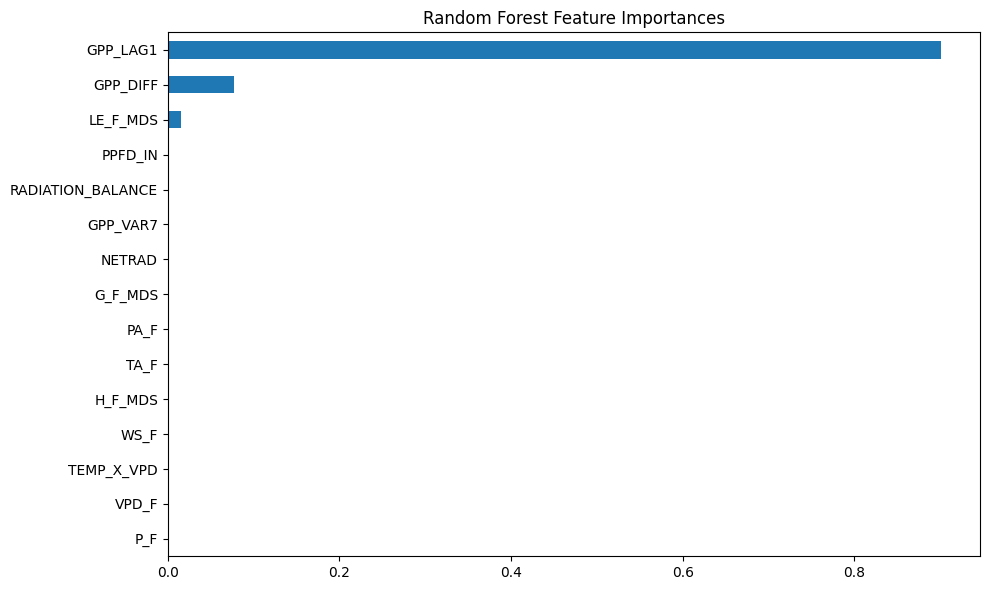

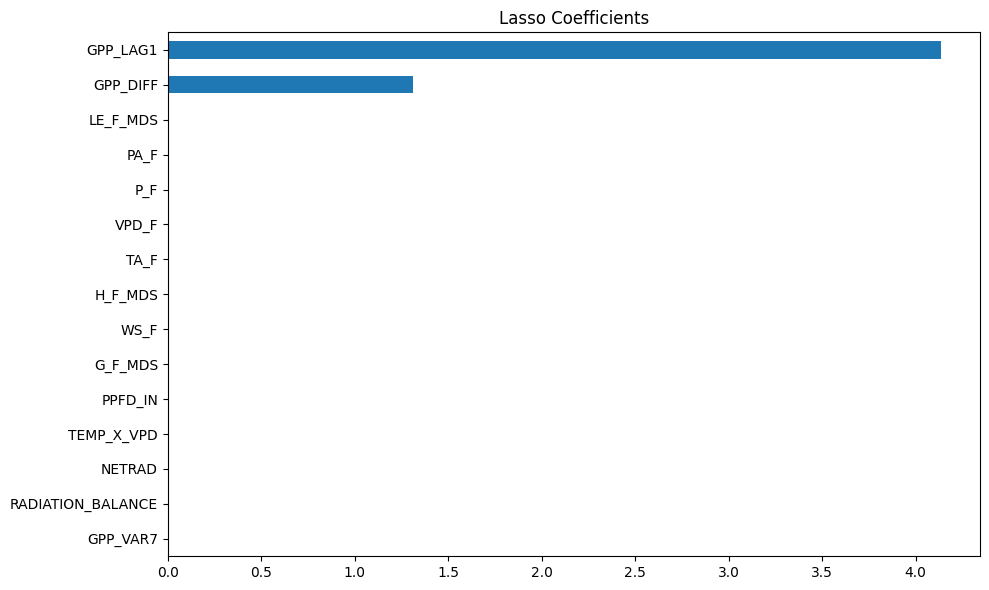

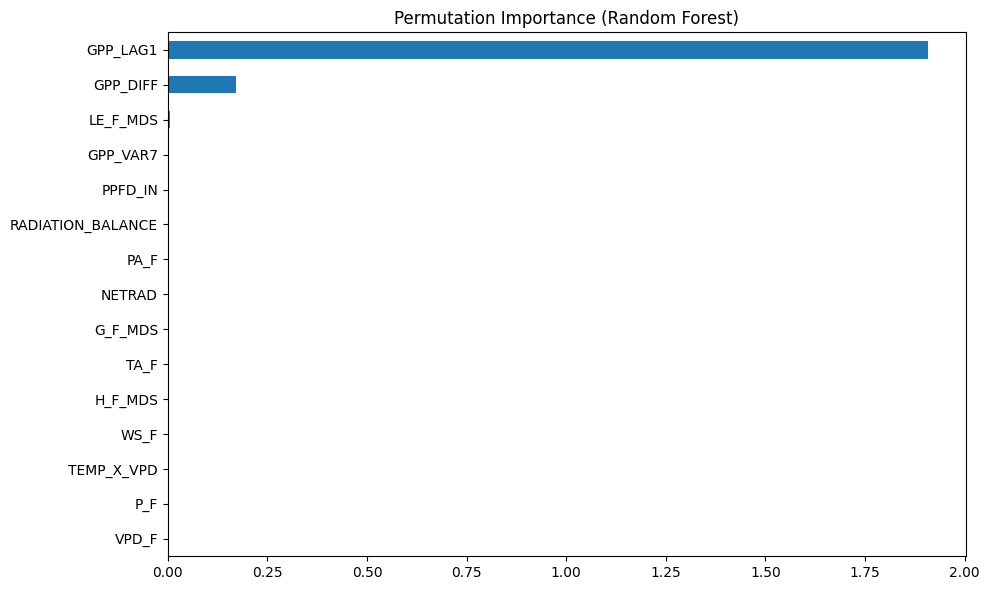


Top 10 Features by Random Forest Importance:
GPP_LAG1             0.901338
GPP_DIFF             0.077184
LE_F_MDS             0.015263
PPFD_IN              0.001854
RADIATION_BALANCE    0.001261
GPP_VAR7             0.000933
NETRAD               0.000915
G_F_MDS              0.000256
PA_F                 0.000230
TA_F                 0.000179
dtype: float64

Top 10 Features by Lasso Coefficients:
GPP_LAG1    4.138041
GPP_DIFF    1.310858
LE_F_MDS    0.003580
PA_F       -0.000000
P_F        -0.000000
VPD_F      -0.000000
TA_F        0.000000
H_F_MDS    -0.000000
WS_F        0.000000
G_F_MDS     0.000000
dtype: float64

Top 10 Features by Permutation Importance:
GPP_LAG1             1.907042
GPP_DIFF             0.169948
LE_F_MDS             0.004425
GPP_VAR7             0.000605
PPFD_IN              0.000426
RADIATION_BALANCE    0.000280
PA_F                 0.000109
NETRAD               0.000106
G_F_MDS              0.000089
TA_F                 0.000057
dtype: float64


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Define X and y
X = df_scaled[predictors]
y = df_scaled[target]  # standardized GPP

# === Feature Importance from Random Forest ===
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)
rf_importance = pd.Series(rf.feature_importances_, index=predictors).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
rf_importance.plot(kind="barh")
plt.title("Random Forest Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("rf_importance.png")
plt.show()

# === Lasso Regularization ===
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X, y)
lasso_importance = pd.Series(lasso.coef_, index=predictors).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
lasso_importance.plot(kind="barh")
plt.title("Lasso Coefficients")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("lasso_importance.png")
plt.show()

# === Permutation Importance ===
perm = permutation_importance(rf, X, y, n_repeats=10, random_state=42, scoring='r2')
perm_importance = pd.Series(perm.importances_mean, index=predictors).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
perm_importance.plot(kind="barh")
plt.title("Permutation Importance (Random Forest)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("perm_importance.png")
plt.show()

# Output top features from each method
print("\nTop 10 Features by Random Forest Importance:")
print(rf_importance.head(10))

print("\nTop 10 Features by Lasso Coefficients:")
print(lasso_importance.head(10))

print("\nTop 10 Features by Permutation Importance:")
print(perm_importance.head(10))


## Hypothesis Update
The highly predictive temporal variables such as GPP_LAG1, GPP_DIFF, and GPP_VAR7 rely on prior knowledge of the target variable. Such features can only be used for forecasting where previous GPP measurements are available. For estimating GPP in new or unmonitored ecosystems, models based on these variables are not applicable. therefore I will identify feature importance excluding any prior knowledge of the target variable

## updated Feature Importance

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
import pandas as pd

# Define past-GPP-related features
gpp_history_features = ["GPP_LAG1", "GPP_DIFF", "GPP_VAR7"]

# Create datasets
predictors_with_gpp = predictors.copy()
predictors_no_gpp = [f for f in predictors if f not in gpp_history_features]

df_with_gpp_history = df_scaled.copy()
df_no_gpp_history = df_scaled.drop(columns=gpp_history_features)

# === Split data ===
X_with_gpp = df_with_gpp_history[predictors_with_gpp]
X_no_gpp = df_no_gpp_history[predictors_no_gpp]
y = df_with_gpp_history[target]

# === Feature Importance of data set without gpp history ===
X_train, X_test, y_train, y_test = train_test_split(X_no_gpp, y, test_size=0.2, random_state=42)

# === Random Forest Importance ===
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_importance = pd.Series(rf.feature_importances_, index=X_no_gpp.columns).sort_values(ascending=False)
print("Top 10 Features by Random Forest Importance (no GPP history):")
print(rf_importance.head(10))

# === Lasso Coefficients ===
lasso = Lasso(alpha=0.01, max_iter=10000)
lasso.fit(X_train, y_train)
lasso_importance = pd.Series(lasso.coef_, index=X_no_gpp.columns).sort_values(ascending=False)
print("\nTop 10 Features by Lasso Coefficients (no GPP history):")
print(lasso_importance.head(10))

# === Permutation Importance ===
perm_importance = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, scoring='r2')
perm_importance_mean = pd.Series(perm_importance.importances_mean, index=X_no_gpp.columns).sort_values(ascending=False)
print("\nTop 10 Features by Permutation Importance (no GPP history):")
print(perm_importance_mean.head(10))


Top 10 Features by Random Forest Importance (no GPP history):
LE_F_MDS             0.767070
TA_F                 0.046172
H_F_MDS              0.036829
VPD_F                0.027992
PA_F                 0.023516
WS_F                 0.022116
RADIATION_BALANCE    0.017600
PPFD_IN              0.015545
G_F_MDS              0.014691
NETRAD               0.013289
dtype: float64

Top 10 Features by Lasso Coefficients (no GPP history):
LE_F_MDS             2.838637
TEMP_X_VPD           1.465660
TA_F                 1.320849
PPFD_IN              0.752925
PA_F                 0.072255
WS_F                 0.001096
NETRAD              -0.000000
RADIATION_BALANCE   -0.000000
G_F_MDS             -0.101492
P_F                 -0.164635
dtype: float64

Top 10 Features by Permutation Importance (no GPP history):
LE_F_MDS             0.983054
TA_F                 0.159471
H_F_MDS              0.087740
VPD_F                0.081969
WS_F                 0.028872
PA_F                 0.022791
RADIATION_

## correlations and clusters

In [ ]:
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# 1. Pairplot for top predictors
top_predictors = ["LE_F_MDS", "TA_F","H_F_MDS", "VPD_F", "WS_F", "PPFD_IN"]
sns.pairplot(df_all[top_predictors + ["GPP_NT_VUT_REF"]])
plt.suptitle("Pairplot of Top Predictors and GPP", y=1.02)
plt.show()

# 2. PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_scaled[top_predictors])
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])

# Apply k-means to detect clusters
kmeans = KMeans(n_clusters=3, random_state=42)
df_pca["cluster"] = kmeans.fit_predict(X_pca)

# Scatter plot of PCA-reduced features with clusters
sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="cluster", palette="Set2")
plt.title("Cluster Visualization of Ecosystem Flux Data (PCA-reduced)")
plt.show()


## Visualize findings

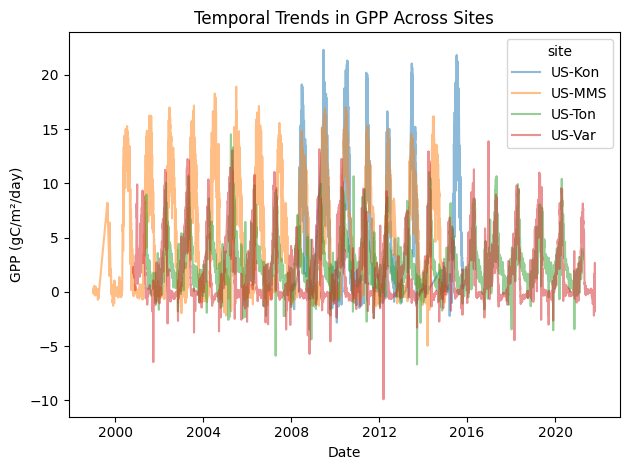

In [ ]:
import matplotlib.dates as mdates

# Convert timestamp to datetime for plotting
df_all["DATE"] = pd.to_datetime(df_all["TIMESTAMP"], format="%Y%m%d")

# Line plot of GPP per site
sns.lineplot(data=df_all, x="DATE", y="GPP_NT_VUT_REF", hue="site", alpha=0.5)
plt.title("Temporal Trends in GPP Across Sites")
plt.ylabel("GPP (gC/m²/day)")
plt.xlabel("Date")
plt.tight_layout()
plt.show()


Understaning the importance of seasons, Engineer 2 more features - month (numerical) and season (categorial)


In [ ]:
# Convert TIMESTAMP to datetime if not already done
df_scaled["DATE"] = pd.to_datetime(df_scaled["TIMESTAMP"].astype(str), format="%Y%m%d")

# Extract month and season
df_scaled["month"] = df_scaled["DATE"].dt.month

# Define season mapping (Northern Hemisphere)
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

df_scaled["season"] = df_scaled["month"].apply(get_season)

# One-hot encode season (for linear models)
season_dummies = pd.get_dummies(df_scaled["season"], prefix="season")
df_scaled = pd.concat([df_scaled, season_dummies], axis=1)

# Add to predictors, drop 'Fall' as baseline
for col in season_dummies.columns:
    if col not in predictors:
        predictors.append(col)

# include 'month' as numeric predictor
if "month" not in predictors:
    predictors.append("month")


# Check sample
df_scaled[["DATE", "month", "season"] + list(season_dummies.columns)].head()


,DATE,month,season,season_Fall,season_Spring,season_Summer,season_Winter
18741,2008-01-07,1,Winter,False,False,False,True
18742,2008-01-08,1,Winter,False,False,False,True
18743,2008-01-09,1,Winter,False,False,False,True
18744,2008-01-10,1,Winter,False,False,False,True
18745,2008-01-11,1,Winter,False,False,False,True


Correlation with GPP (season dummies):
GPP_NT_VUT_REF    1.00
season_Winter    -0.27
season_Spring     0.22
season_Summer     0.26
season_Fall      -0.22
Name: GPP_NT_VUT_REF, dtype: float64


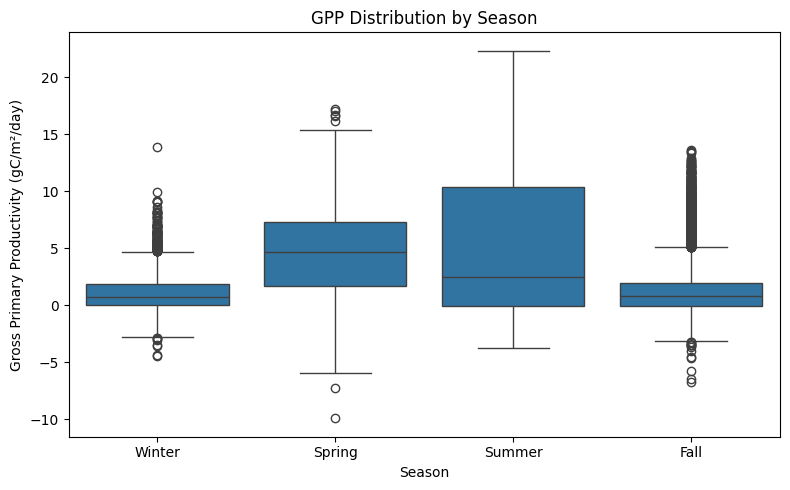

In [ ]:
# Correlation of each season dummy with GPP
season_corr = df_scaled[["GPP_NT_VUT_REF", "season_Winter", "season_Spring", "season_Summer", "season_Fall"]].corr()
print("Correlation with GPP (season dummies):")
print(season_corr["GPP_NT_VUT_REF"].round(2))

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.boxplot(x="season", y="GPP_NT_VUT_REF", data=df_scaled)
plt.title("GPP Distribution by Season")
plt.ylabel("Gross Primary Productivity (gC/m²/day)")
plt.xlabel("Season")
plt.tight_layout()
plt.show()


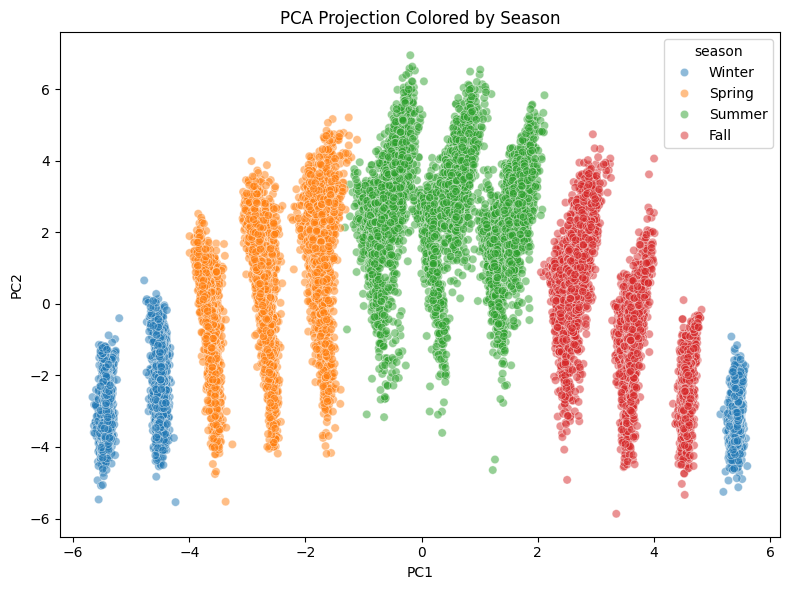

Top 10 loadings for PC1:
month                0.983884
season_Fall          0.075557
TA_F                 0.061768
season_Spring       -0.058618
LE_F_MDS            -0.056470
VPD_F                0.055869
TEMP_X_VPD           0.054648
RADIATION_BALANCE   -0.045811
NETRAD              -0.045302
GPP_LAG1            -0.044697
Name: PC1, dtype: float64

Top 10 loadings for PC2:
PPFD_IN              0.376109
RADIATION_BALANCE    0.357780
NETRAD               0.349454
TA_F                 0.336697
VPD_F                0.330636
G_F_MDS              0.325017
TEMP_X_VPD           0.319314
H_F_MDS              0.298334
LE_F_MDS             0.144524
WS_F                -0.130640
Name: PC2, dtype: float64


In [ ]:
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Run PCA on standardized predictors (excluding GPP and season dummies)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled[predictors])

# Add to DataFrame for plotting
pca_df = pd.DataFrame(pca_result, columns=["PC1", "PC2"])
pca_df["season"] = df_scaled["season"].values

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="season", alpha=0.5)
plt.title("PCA Projection Colored by Season")
plt.tight_layout()
plt.show()

# Create a DataFrame of PCA loadings
loadings = pd.DataFrame(
    pca.components_.T,
    columns=["PC1", "PC2"],
    index=df_scaled[predictors].columns
)

# Sort by absolute value to find top contributing features
top_pc1 = loadings["PC1"].abs().sort_values(ascending=False).head(10)
top_pc2 = loadings["PC2"].abs().sort_values(ascending=False).head(10)

# Display top features contributing to PC1 and PC2
print("Top 10 loadings for PC1:")
print(loadings.loc[top_pc1.index, "PC1"])

print("\nTop 10 loadings for PC2:")
print(loadings.loc[top_pc2.index, "PC2"])

Top 10 loadings for PC1:
month                0.983884
season_Fall          0.075557
Air Temperature      0.061768
season_Spring       -0.058618
Latent Heat Flux    -0.056470
Vapor Pressure       0.055869
TEMP_X_VPD           0.054648
RADIATION_BALANCE   -0.045811
Net Radiation       -0.045302
GPP_LAG1            -0.044697
Name: PC1, dtype: float64

Top 10 loadings for PC2:
Photosynthetic Photon Flux Density    0.376109
RADIATION_BALANCE                     0.357780
Net Radiation                         0.349454
Air Temperature                       0.336697
Vapor Pressure                        0.330636
Ground Heat Flux                      0.325017
TEMP_X_VPD                            0.319314
Sensible Heat Flux                    0.298334
Latent Heat Flux                      0.144524
Wind Speed                           -0.130640
Name: PC2, dtype: float64


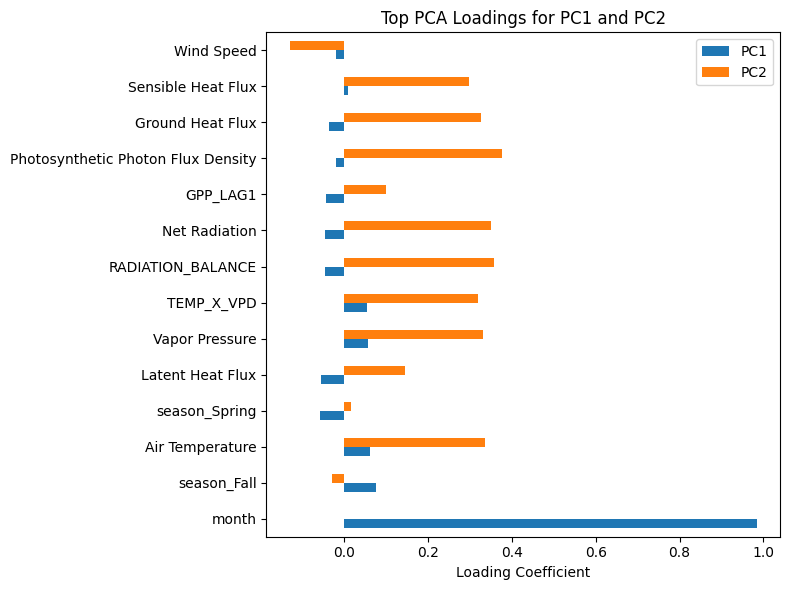

In [ ]:
# Define name mapping again (if not already in scope)
feature_names = {
    "GPP_NT_VUT_REF": "Gross Primary Productivity",
    "TA_F": "Air Temperature",
    "VPD_F": "Vapor Pressure",
    "PPFD_IN": "Photosynthetic Photon Flux Density",
    "PA_F": "Air Pressure",
    "P_F": "Precipitation",
    "WS_F": "Wind Speed",
    "LE_F_MDS": "Latent Heat Flux",
    "H_F_MDS": "Sensible Heat Flux",
    "G_F_MDS": "Ground Heat Flux",
    "NETRAD": "Net Radiation"
}

# Create DataFrame of loadings
loadings = pd.DataFrame(
    pca.components_.T,
    columns=["PC1", "PC2"],
    index=df_scaled[predictors].columns
)

# Top 10 contributing features for each component
top_pc1 = loadings["PC1"].abs().sort_values(ascending=False).head(10)
top_pc2 = loadings["PC2"].abs().sort_values(ascending=False).head(10)

# Rename features using dictionary
loadings_renamed = loadings.rename(index=lambda x: feature_names.get(x, x))

# Display results
print("Top 10 loadings for PC1:")
print(loadings_renamed.loc[top_pc1.index.map(lambda x: feature_names.get(x, x)), "PC1"])

print("\nTop 10 loadings for PC2:")
print(loadings_renamed.loc[top_pc2.index.map(lambda x: feature_names.get(x, x)), "PC2"])

# Combine top features (raw names)
top_features_raw = pd.concat([top_pc1, top_pc2]).index.unique()

# Map to readable names
top_features_named = [feature_names.get(f, f) for f in top_features_raw]

# Subset loadings using readable names
loadings_renamed.loc[top_features_named].plot(kind='barh', figsize=(8, 6))
plt.title("Top PCA Loadings for PC1 and PC2")
plt.xlabel("Loading Coefficient")
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


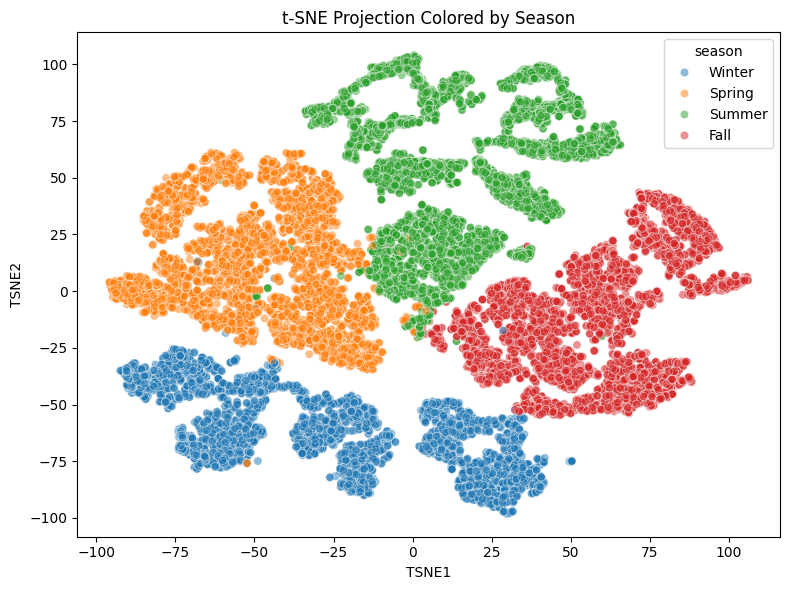

In [ ]:
from sklearn.manifold import TSNE

# Run t-SNE on scaled predictors
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_result = tsne.fit_transform(df_scaled[predictors])

# Add to DataFrame for plotting
tsne_df = pd.DataFrame(tsne_result, columns=["TSNE1", "TSNE2"])
tsne_df["season"] = df_all["season"].values

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=tsne_df, x="TSNE1", y="TSNE2", hue="season", alpha=0.5)
plt.title("t-SNE Projection Colored by Season")
plt.tight_layout()
plt.show()
